In [2]:
%cd ..
%load_ext autoreload
%autoreload 2
import sensor_lib as sl

/home/jovyan/RQC-Robotics-tactile_sensor


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import yaml

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
geo = config['env']['sen_geometry']
phys = config['env']['phys']

In [10]:
np.random.seed(config['random_seed'])
seeds = np.random.randint(0, 2**32, size=3)

# generation pressure_map

In [11]:
x = geo['x_len']
y = geo['y_len']
n_pic = config['dataset']['n_sampels']
n_gaus = config['env']['presure_profile']['n_gauses']
size_kof = config['env']['presure_profile']['size_kof']
vec_mat = tf.constant(sl.get_vec_mat(x, y), dtype=tf.float32)
vec_mat = tf.reshape(vec_mat, [-1, 2])
gaus_data = sl.gen_rand_cof(n_gaus * n_pic, x, y, size_kof,
                            seed=seeds[0])  # use random inside
with open(config['env']['presure_profile']['g_param_path'], 'wb+') as f:
    np.save(f, gaus_data)
gaus_data = tf.reshape(gaus_data, [n_pic, n_gaus, 5])
pictures = sl.generate_pictures(gaus_data, vec_mat)
pictures = tf.reshape(pictures, [n_pic, x, y])

limit by hat fun

In [12]:
norm = sl.round_fun([x, y], [x / 2, y / 2], lambda l: sl.hat(l, x / 2))
pictures = pictures * norm

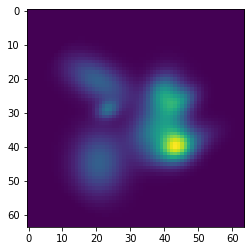

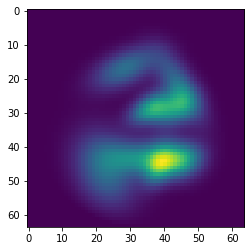

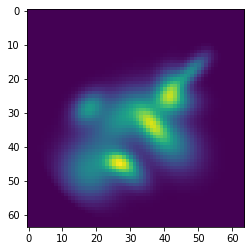

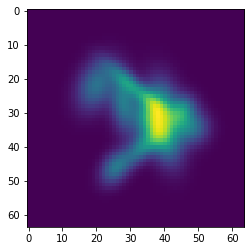

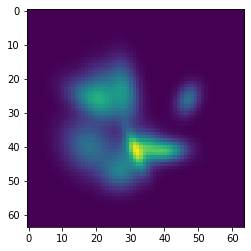

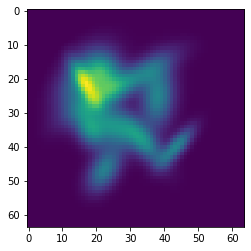

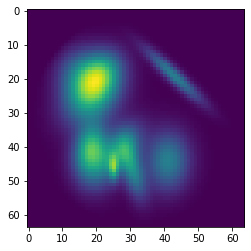

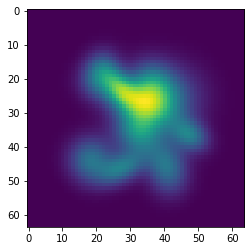

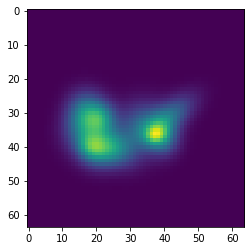

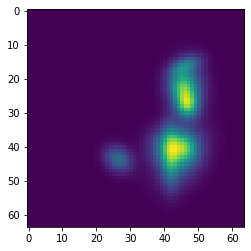

In [13]:
for i in range(10):
    plt.imshow(pictures[i])
    plt.show()

In [16]:
with open(jn(config['dataset']['pic_path'], 'one_piece.npy'), 'wb+') as f:
    np.save(f, pictures)

# counting losses in fibers (input of nerual network)

In [17]:
    size = None
    max_possible_size = config['sim']['max_possible_size']
    test_size = config['sim']['test_size']
    batch_size = config['sim']['batch_size']
    n_del = geo['n_spl']
    mas = np.load(jn(config['dataset']['pic_path'],'one_piece.npy'), mmap_mode='r')
    if size == None:
        size = min(mas.shape[0], max_possible_size)
    if test_size == 'None':
        test_size = int(size / 10)
    mas = mas[0:size]
    mas = mas.astype('float32')

In [19]:
config['sim']['test_mod'] = False
input, output, input_test, output_test = sl.sim_on_gpu(
    mas, test_size, batch_size, config=config,
    seed=seeds[1])  # use random inside

# defining nerual network for decoding and fitting it

In [23]:
print('input shape: ', input.shape, '\noutput shape: ', output.shape)

input shape:  (14, 64, 4) 
output shape:  (14, 64, 64)


In [25]:
tr = config['train']
model = sl.SensorNN5S_norm_deep(input.shape, output.shape)
model.build(input.shape)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(tr['lerning_rate']),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model_name = 'SensorNN5S_norm_deep'

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 4)]      0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 64, 4, 1)     0           ['input_2[0][0]']                
                                                                                                  
 Conv_1.1 (Conv2D)              (None, 64, 4, 8)     32          ['reshape_2[0][0]']              
                                                                                                  
 MaxPool_1.1 (MaxPooling2D)     (None, 32, 4, 8)     0           ['Conv_1.1[0][0]']               
                                                                                            

In [31]:
# model.fit(dataset_b, epochs=n_epochs, verbose=1)
tf.keras.utils.set_random_seed(seed=int(seeds[2]))  # use random
model.fit(input, output, epochs=tr['n_epochs'], verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 817ms/step - loss: 0.1986 - accuracy: 0.0201
Epoch 2/20
1/1 [==============================] - 0s 42ms/step - loss: 0.1981 - accuracy: 0.0201
Epoch 3/20
1/1 [==============================] - 0s 56ms/step - loss: 0.1977 - accuracy: 0.0212
Epoch 4/20
1/1 [==============================] - 0s 53ms/step - loss: 0.1972 - accuracy: 0.0212
Epoch 5/20
1/1 [==============================] - 0s 66ms/step - loss: 0.1967 - accuracy: 0.0212
Epoch 6/20
1/1 [==============================] - 0s 55ms/step - loss: 0.1962 - accuracy: 0.0212
Epoch 7/20
1/1 [==============================] - 0s 57ms/step - loss: 0.1957 - accuracy: 0.0223
Epoch 8/20
1/1 [==============================] - 0s 68ms/step - loss: 0.1951 - accuracy: 0.0234
Epoch 9/20
1/1 [==============================] - 0s 62ms/step - loss: 0.1946 - accuracy: 0.0234
Epoch 10/20
1/1 [==============================] - 0s 62ms/step - loss: 0.1941 - accuracy: 0.0234
Epoch 11/20
1/1 [===========

In [32]:
model.save(jn(tr['models_path'], model_name + '.nn'))

INFO:tensorflow:Assets written to: models/SensorNN5S_norm_deep.nn/assets


INFO:tensorflow:Assets written to: models/SensorNN5S_norm_deep.nn/assets


# evoluate model on don't seen data

In [33]:
model = tf.keras.models.load_model(jn(tr['models_path'], model_name + '.nn'))

In [34]:
model.evaluate(input_test, output_test)

1/1 [==============================] - 0s 214ms/step - loss: 0.1581 - accuracy: 0.0000e+00


[0.15812382102012634, 0.0]

In [35]:
predictions = model.predict(input_test)
predictions.shape

1/1 [==============================] - 0s 159ms/step


(1, 64, 64)

# saving resalts

In [36]:
ev = config['evaluate']

In [37]:
with open(jn(ev['pred_path'], 'pred.npy'), 'wb') as f:
    np.save(f, predictions)
with open(jn(ev['pred_path'], 'true.npy'), 'wb') as f:
    np.save(f, output_test)

# look on resalts

In [40]:
with open(jn(ev['pred_path'], 'pred.npy'), 'rb') as f:
    predictions = np.load(f)
with open(jn(ev['pred_path'], 'true.npy'), 'rb') as f:
    output_test = np.load(f)

len=  1


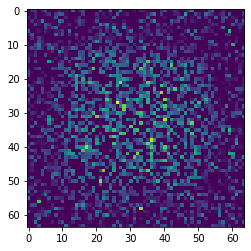

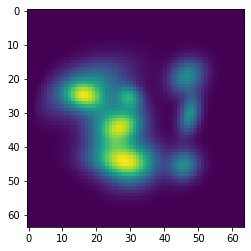

In [41]:
print('len= ', len(predictions))
N = 0  # number of exampel
plt.imshow(predictions[N])
plt.show()
plt.imshow(output_test[N])
plt.show()